In [154]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pypalettes import load_cmap
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from highlight_text import fig_text, ax_text

df = pd.read_csv('GCB2022v27_percapita_flat.csv')
df = df[df['Year']==df['Year'].max()]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['continent'] == 'Europe']
data = world.merge(df, how='left', left_on='name', right_on='Country')
data = data[~data['Country'].isin(['Russia', 'Iceland'])]
data = data[['Country', 'Total', 'geometry']]
data = data.dropna()
data = data.sort_values('Total', ascending=False)
data.columns = ['country', 'co2Capita', 'geometry']
data.to_file('data.geojson', driver='GeoJSON')
data.sample(3)

/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_38143/1215168215.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,country,co2Capita,geometry
3,Sweden,3.424918,"POLYGON ((11.02737 58.85615, 11.46827 59.43239..."
20,Luxembourg,13.067857,"POLYGON ((6.04307 50.12805, 6.24275 49.90223, ..."
22,Netherlands,8.058958,"POLYGON ((6.90514 53.48216, 7.09205 53.14404, ..."


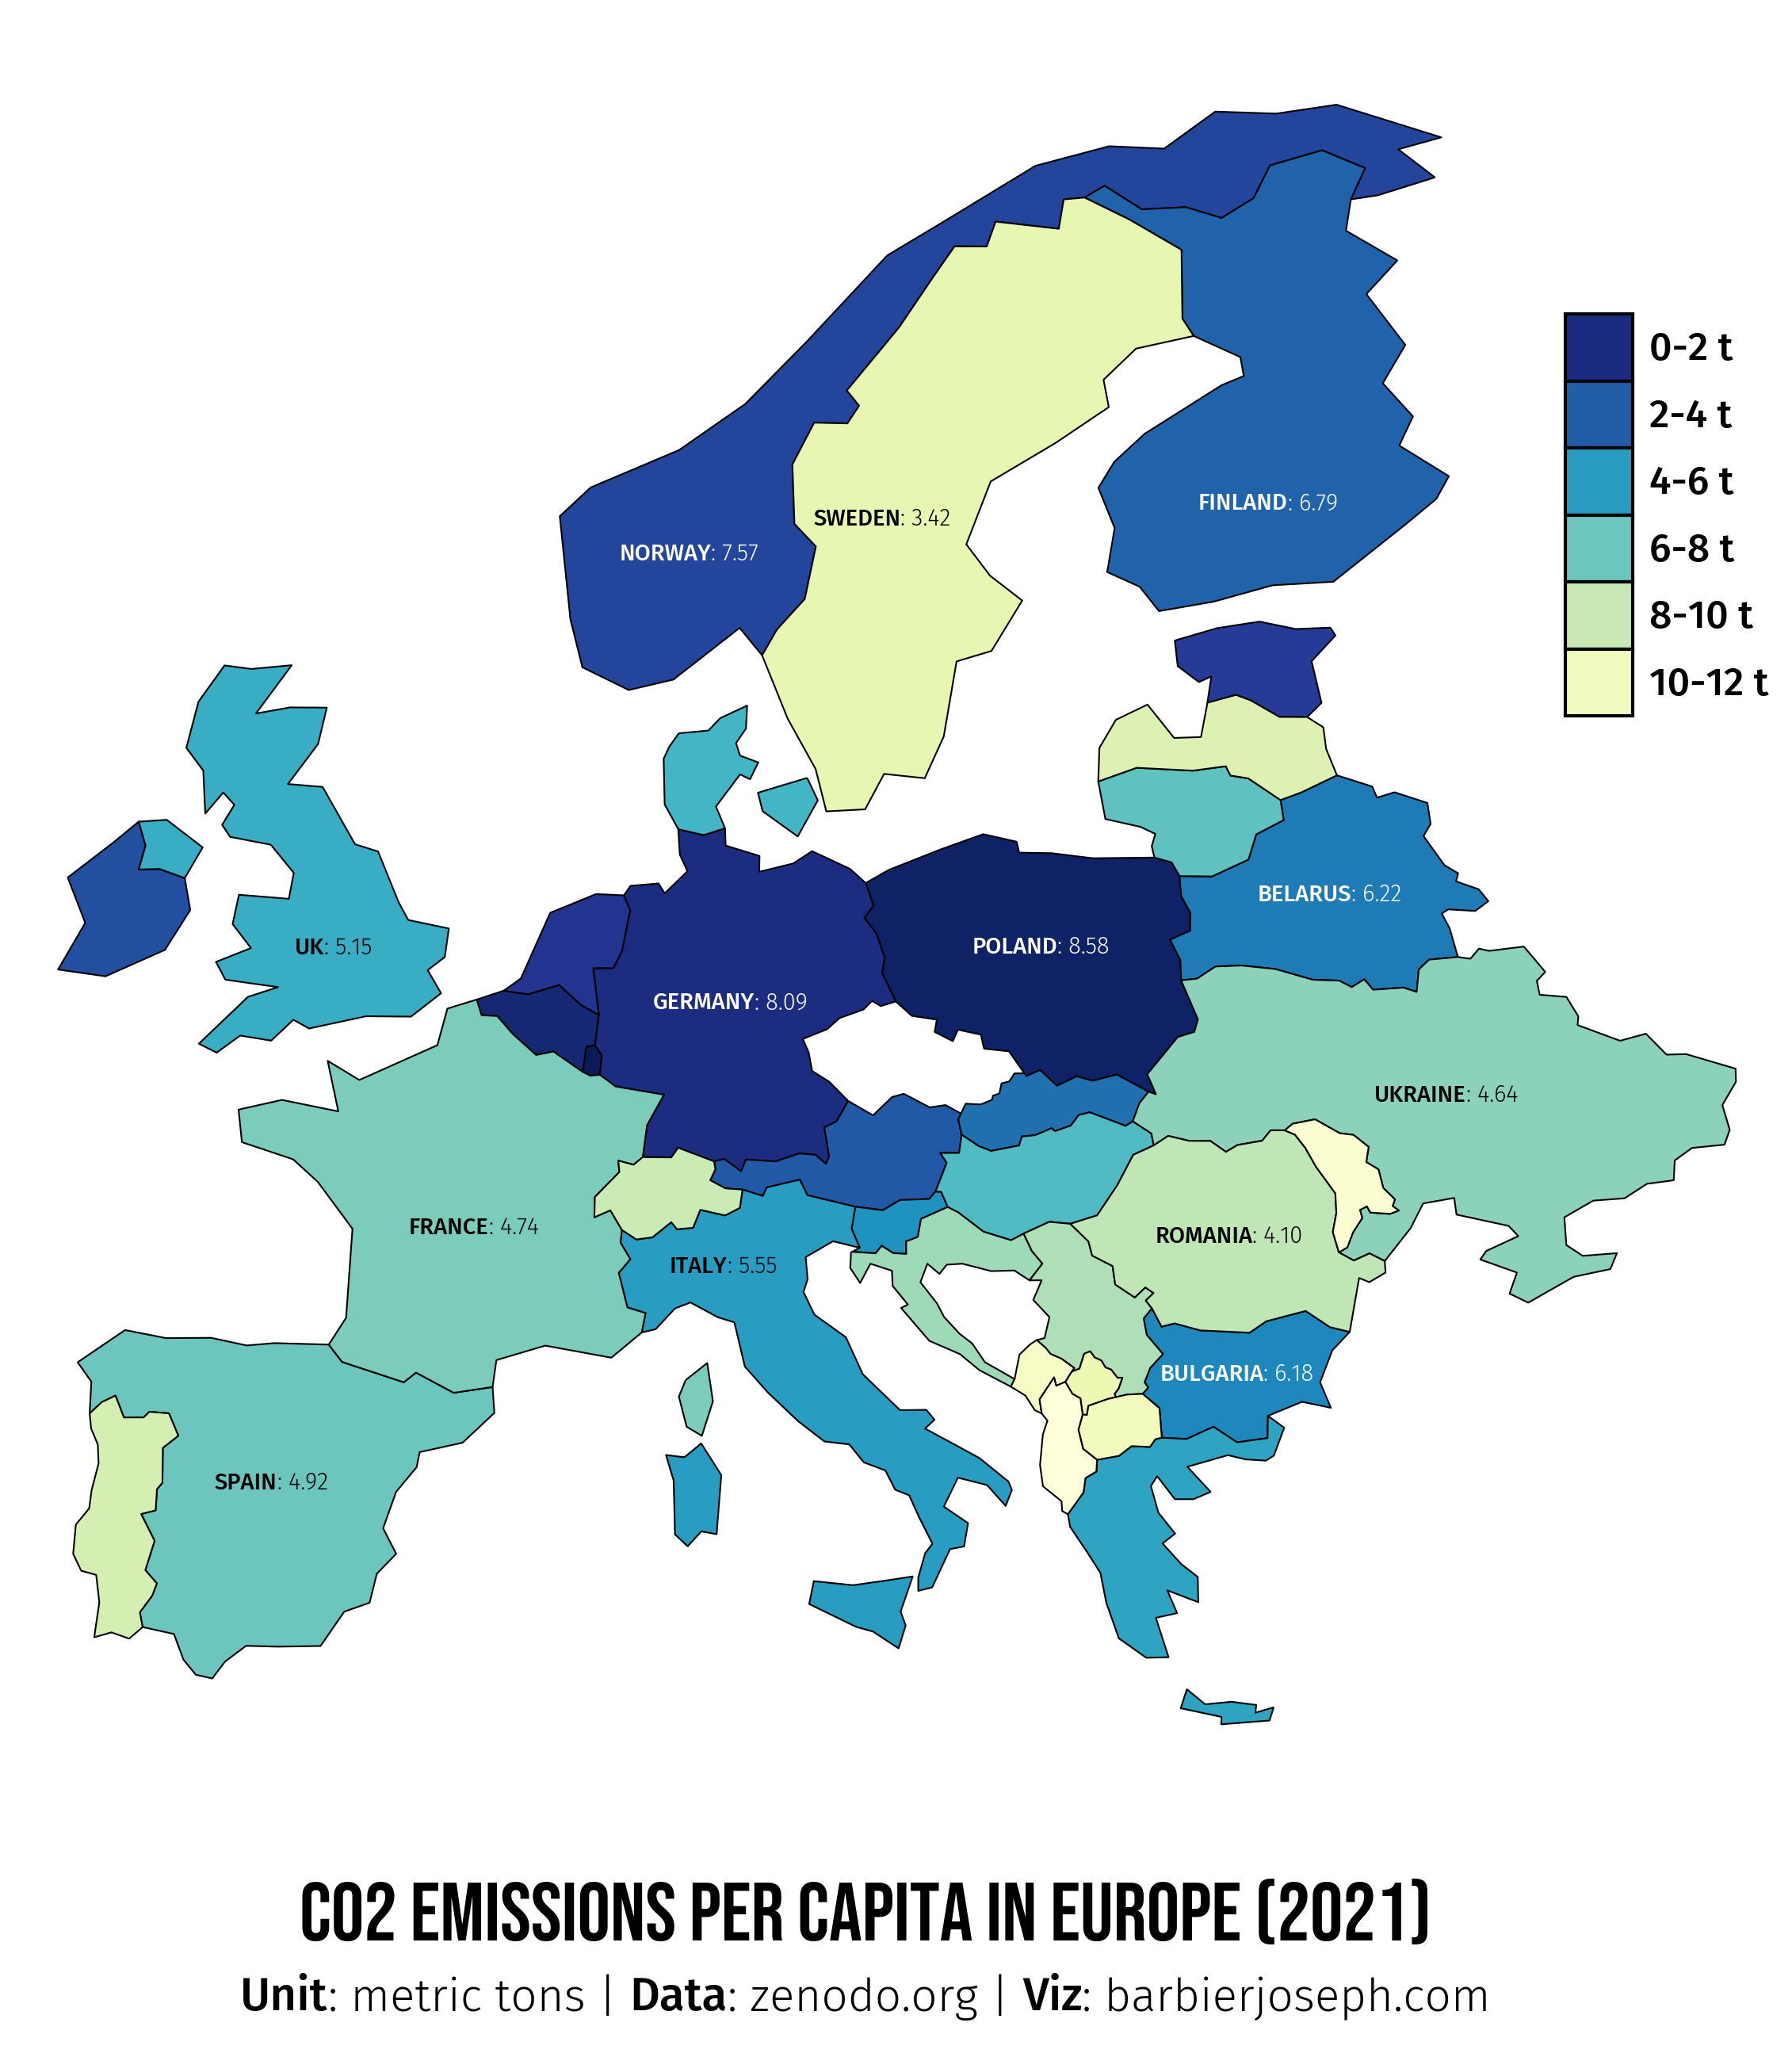

In [155]:
# load the colormap
cmap = load_cmap('YlGnBu', type='continuous', reverse=True)
background_color = 'white'
text_color = 'black'

# legend values
value_ranges = [0, 2, 4, 6, 8, 10, 12]
labels = ['0-2 t', '2-4 t', '4-6 t', '6-8 t', '8-10 t', '10-12 t', '12+ t']
def create_legend_elements(cmap, value_ranges, labels):
    legend_elements = []
    n = len(value_ranges)
    for i in range(n-1):
        value = (value_ranges[i] + value_ranges[i+1]) / 2 / value_ranges[-1]  # Normalize the value to [0, 1]
        legend_elements.append(Patch(facecolor=cmap(value), label=labels[i]))
    return legend_elements
legend_elements = create_legend_elements(cmap, value_ranges, labels)

# load the font
personal_path = '/Users/josephbarbier/Library/Fonts/'
font = FontProperties(fname=personal_path + 'BebasNeue-Regular.ttf')
other_font = FontProperties(fname=personal_path + 'FiraSans-Light.ttf')
other_bold_font = FontProperties(fname=personal_path + 'FiraSans-Medium.ttf')

# initialize the figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
fig.set_facecolor(background_color)

# create the plot
data.plot(ax=ax, cmap=cmap, edgecolor='black', linewidth=0.5)

# custom axis
ax.set_xlim(-11, 41)
ax.set_ylim(32, 73)
ax.set_axis_off()

# add the patches to the plot area as a legend
rectangle_width = 2
rectangle_height = 1.5
legend_x = 35
legend_y_start = 65
legend_y_step = 1.5
for i, element in enumerate(legend_elements):
    ax.add_patch(plt.Rectangle((legend_x, legend_y_start - i * legend_y_step), rectangle_width, rectangle_height,
                               color=element.get_facecolor(), ec='black'))
    ax.text(legend_x + 2.5, legend_y_start - i * legend_y_step + 0.7, element.get_label(), 
            fontsize=12, fontproperties=other_bold_font, color=text_color, va='center')

# compute centroids and display the total
adjustments = {
    'France': (10, 3),
    'Italy': (-2.4, 2.5),
    'Lithuania': (0, -0.6),
    'Finland': (0, -2),
    'Romania': (0, 0),
    'Bulgaria': (0, 0),
    'Greece': (-1.2, -0.8),
    'Croatia': (0, -1),
    'Cyprus': (0, -1),
    'Ireland': (0, -1),
    'Malta': (0, -1),
    'Slovenia': (0, -1),
    'Slovakia': (-0.7, -0.8),
    'Estonia': (0, -0.7),
    'Latvia': (0, -0.5),
    'Belgium': (0, -0.7),
    'Austria': (0, -0.4),
    'Spain': (0, 0),
    'Portugal': (-0.5, -1),
    'Luxembourg': (0, -1),
    'Germany': (-0.2, 0),
    'Hungary': (-0.3, -1),
    'Czechia': (0, -1),
    'Poland': (0, 0.2),
    'Sweden': (-1.5, -0.5),
    'Denmark': (0, -1),
    'Netherlands': (0, 0),
    'United Kingdom': (1, -1.5),
    'Switzerland': (0, -0.5),
    'Norway': (-4, -5.5),
}
data_projected = data.to_crs(epsg=3035)
data_projected['centroid'] = data_projected.geometry.centroid
data['centroid'] = data_projected['centroid'].to_crs(data.crs)
countries_to_annotate = data['country'].tolist()
countries_to_annotate = [
   'France', 'Italy', 'Romania', 'Poland',
   'Finland', 'Ukraine',
   'Spain', 'Germany', 
   'Sweden', 'United Kingdom', 'Bulgaria',
   'Belarus', 'Norway'
]
for country in countries_to_annotate:
   centroid = data.loc[data['country'] == country, 'centroid'].values[0]
   x, y = centroid.coords[0]
   try:
      x += adjustments[country][0]
      y += adjustments[country][1]
   except KeyError:
      pass
   rate = data.loc[data['country'] == country, 'co2Capita'].values[0]
   if country=='United Kingdom':
      country = 'UK'
   if rate > 6:
      color_text = 'white'
   else:
      color_text = text_color
   ax_text(
      x=x, y=y, s=f"<{country.upper()}>: {rate:.2f}", fontsize=7, font=other_font, color=color_text,
      ha='center', va='center', ax=ax, highlight_textprops=[{'font': other_bold_font}]
   )

# title
fig_text(
   s="CO2 emissions per capita in Europe (2021)", x=0.5, y=0.1,
   color=text_color, fontsize=25, font=font, ha='center', va='top', ax=ax
)

# subtitle
fig_text(
   s="<Unit>: metric tons | <Data>: zenodo.org | <Viz>: barbierjoseph.com", x=0.5, y=0.06,
   color=text_color, fontsize=14, font=other_font, ha='center', va='top', ax=ax,
   highlight_textprops=[{'font': other_bold_font}, {'font': other_bold_font}, {'font': other_bold_font}]
)

# display the plot
plt.savefig('map.png', dpi=300)
plt.show()

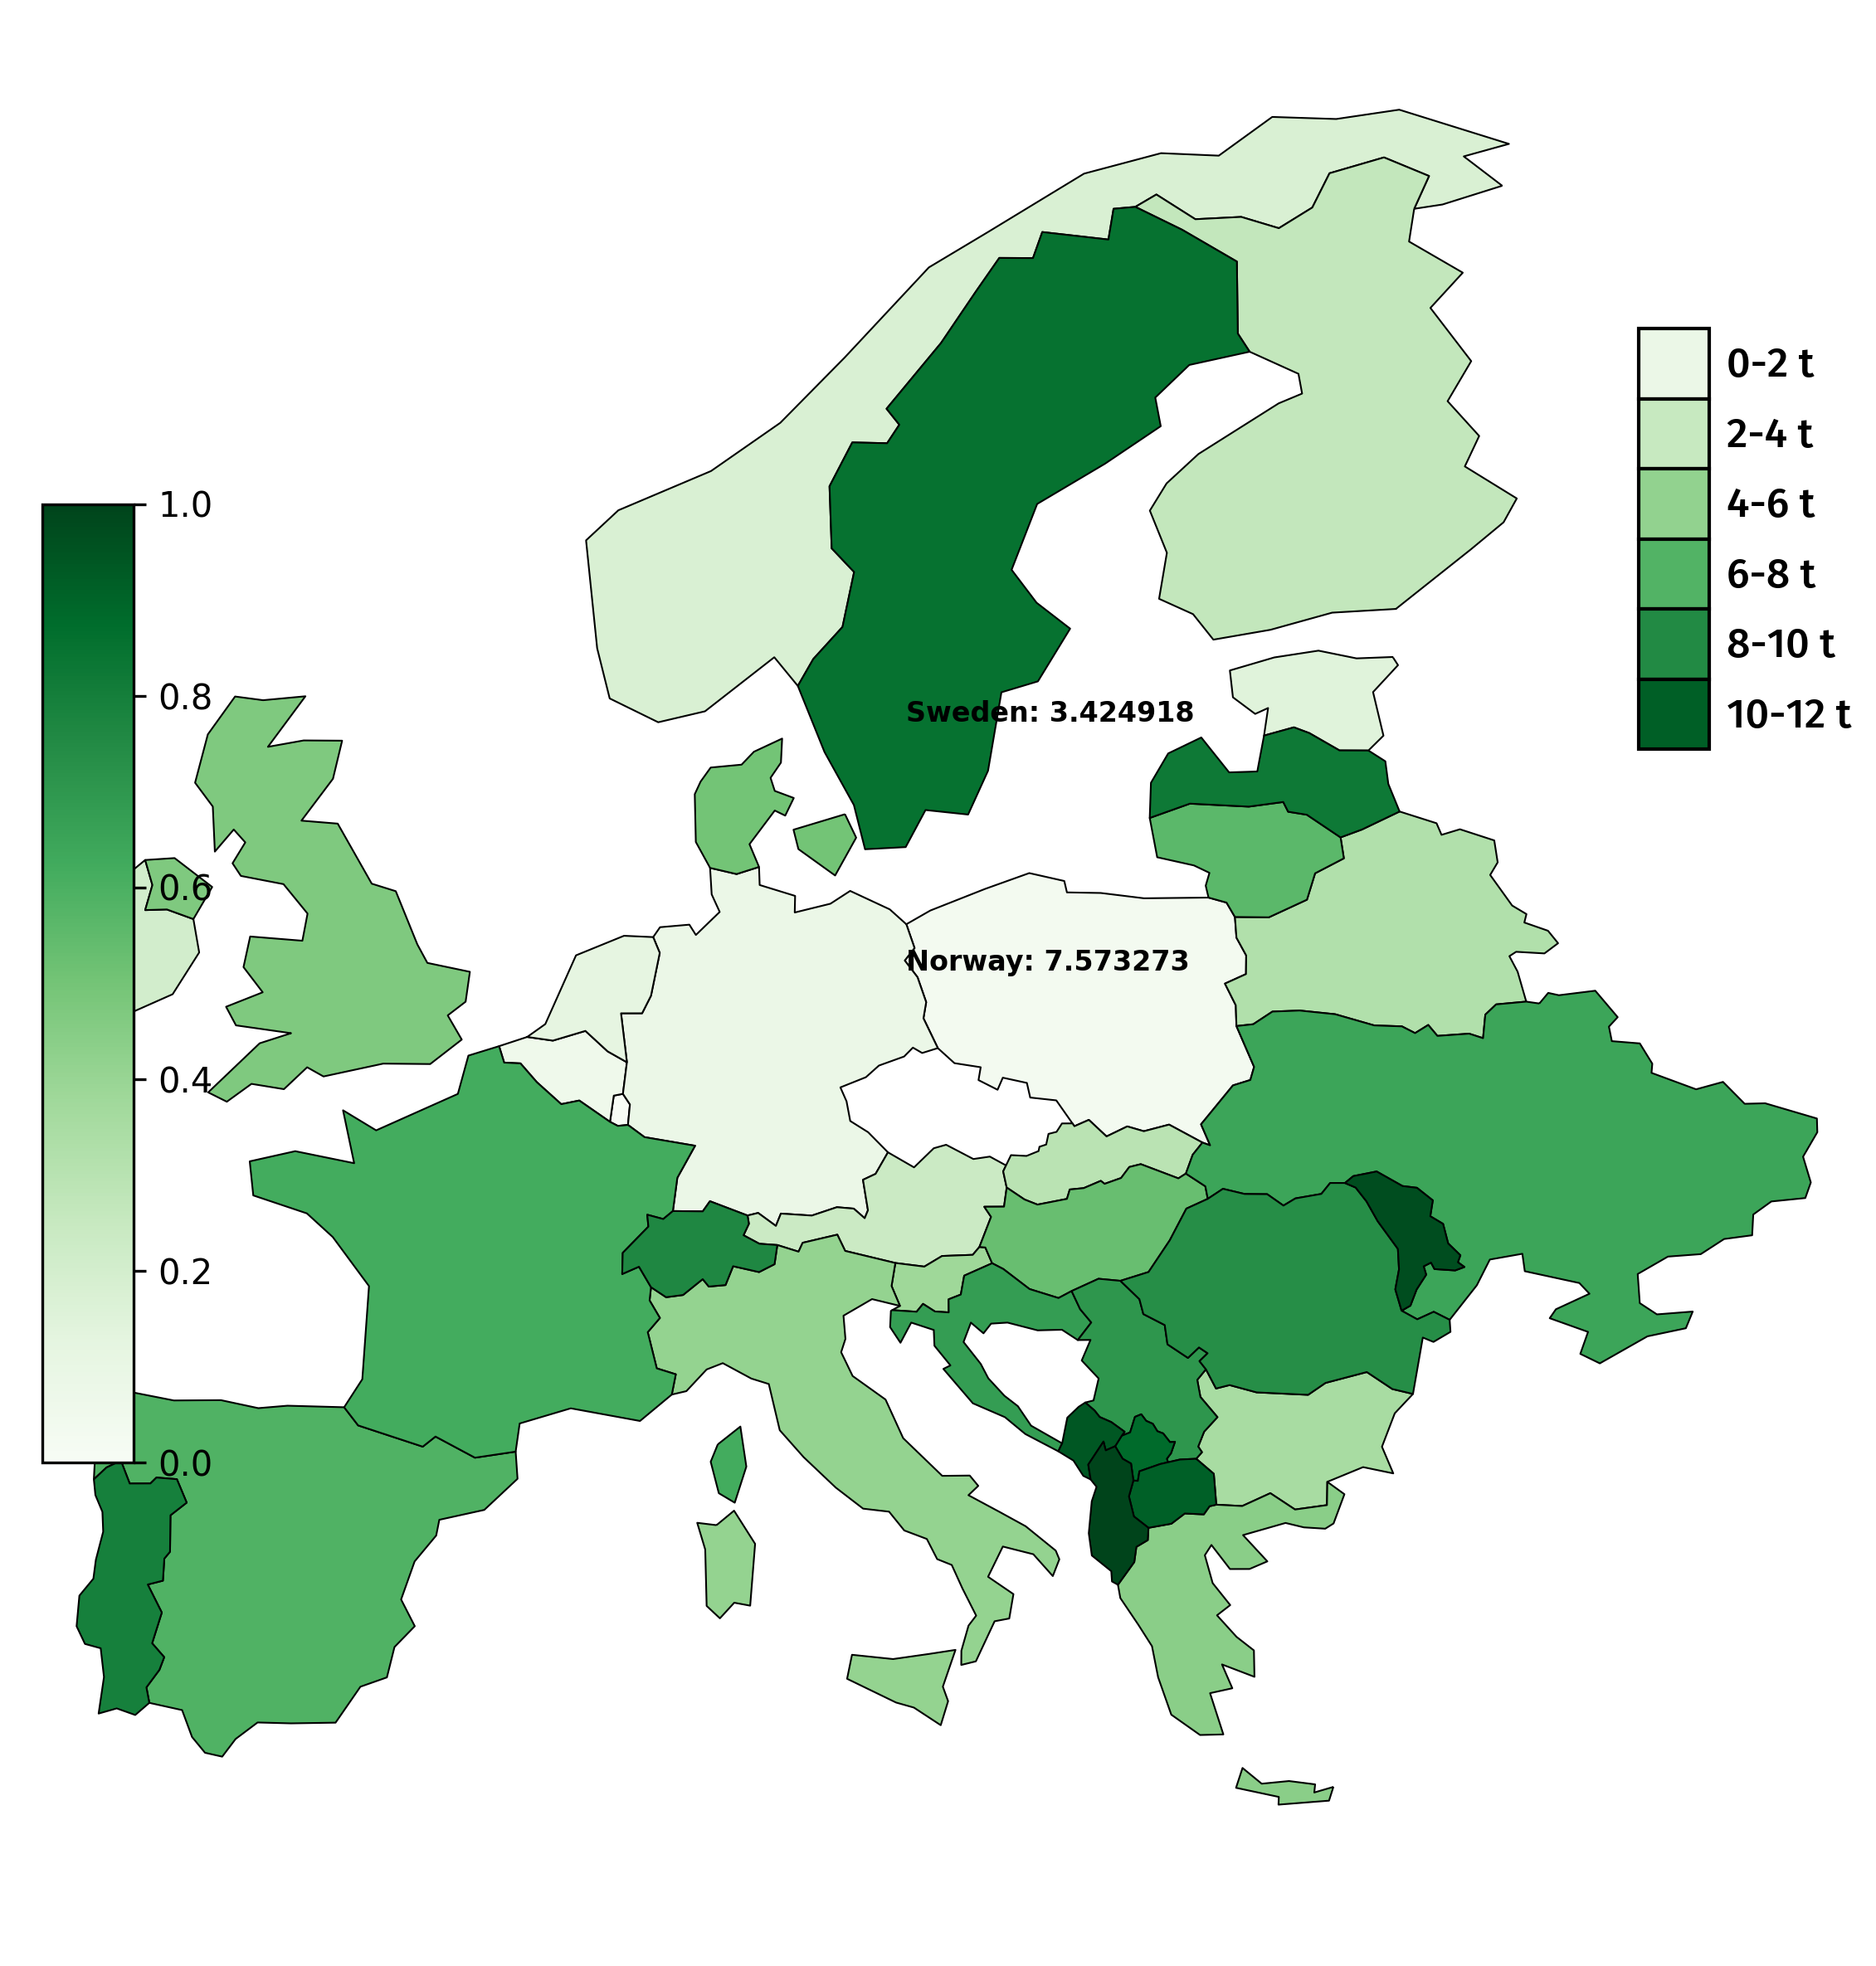

In [162]:
import matplotlib.cm as cm
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

data = gpd.read_file('https://raw.githubusercontent.com/JosephBARBIERDARNAL/misc-dataviz/main/country-co2/data.geojson')
# load the colormap
cmap = cm.Greens
background_color = 'white'
text_color = 'black'

# legend values
value_ranges = [0, 2, 4, 6, 8, 10, 12]
labels = ['0-2 t', '2-4 t', '4-6 t', '6-8 t', '8-10 t', '10-12 t', '12+ t']
def create_legend_elements(cmap, value_ranges, labels):
    legend_elements = []
    n = len(value_ranges)
    for i in range(n-1):
        value = (value_ranges[i] + value_ranges[i+1]) / 2 / value_ranges[-1]  # Normalize the value to [0, 1]
        legend_elements.append(Patch(facecolor=cmap(value), label=labels[i]))
    return legend_elements
legend_elements = create_legend_elements(cmap, value_ranges, labels)

# initialize the figure
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
fig.set_facecolor(background_color)

# create the plot
data.plot(ax=ax, cmap=cmap, edgecolor='black', linewidth=0.5)

# annot norway and sweden
norway = data.loc[data['country'] == 'Norway']['co2Capita'].values[0]
sweden = data.loc[data['country'] == 'Sweden']['co2Capita'].values[0]
fig.text(0.5, 0.5, f'Norway: {norway}', fontsize=8, fontweight='bold', color='black')
fig.text(0.5, 0.6, f'Sweden: {sweden}', fontsize=8, fontweight='bold', color='black')

# custom axis
ax.set_xlim(-11, 41)
ax.set_ylim(32, 73)
ax.set_axis_off()

# add the patches to the plot area as a legend
rectangle_width = 2
rectangle_height = 1.5
legend_x = 35
legend_y_start = 65
legend_y_step = 1.5
for i, element in enumerate(legend_elements):
    ax.add_patch(plt.Rectangle((legend_x, legend_y_start - i * legend_y_step), rectangle_width, rectangle_height,
                               color=element.get_facecolor(), ec='black'))
    ax.text(legend_x + 2.5, legend_y_start - i * legend_y_step + 0.7, element.get_label(), 
            fontsize=12, fontproperties=other_bold_font, color=text_color, va='center')
    
# add colorbar
cax = inset_axes(ax, width='5%', height='50%', loc='center left')
sm = plt.cm.ScalarMappable(cmap=cmap)
sm._A = []
cbar = plt.colorbar(sm, cax=cax)
                 
plt.show()